In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
import yaml
from tqdm import tqdm
import torchvision.transforms.v2 as v2
from copy import deepcopy
import sys
sys.path.append("/n/home03/creissel/phlab-neurips25")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from models.litmodels import SimCLRModel
from models.networks import CustomResNet, MLP
from data.datasets import Histology
import data.data_utils as dutils

from sklearn.metrics import roc_auc_score, top_k_accuracy_score
from utils.plotting import make_corner

/n/holylabs/LABS/iaifi_lab/Users/creissel/miniforge3/envs/ssm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
CHECKPOINT = '/n/home03/creissel/phlab-neurips25/runs/histology_simCLR_EffNet_T0.5/lightning_logs/9jr9l23x/checkpoints/epoch=22-step=25484.ckpt'

# evaluate pre-trained model

In [29]:
dataset = Histology(batch_size=32,num_workers=2)
dataset_test = dataset.test_dataset
dataset_train = dataset.train_dataset

dataset_shift = Histology(staining='he', batch_size=32,num_workers=2)

model = SimCLRModel.load_from_checkpoint(CHECKPOINT)
model = model.to(device)
model = model.eval()

number of requested samples (10000) is larger then the size of the dataset (6922) in: /n/home11/nswood/anomaly-detection-in-histology/data/train/mt_mouse_brain. Using all available samples.
number of requested samples (10000) is larger then the size of the dataset (6922) in: /n/home11/nswood/anomaly-detection-in-histology/data/train/mt_mouse_heart. Using all available samples.
number of requested samples (10000) is larger then the size of the dataset (6922) in: /n/home11/nswood/anomaly-detection-in-histology/data/train/mt_mouse_kidney. Using all available samples.
number of requested samples (10000) is larger then the size of the dataset (6921) in: /n/home11/nswood/anomaly-detection-in-histology/data/train/mt_mouse_liver. Using all available samples.
number of requested samples (10000) is larger then the size of the dataset (6922) in: /n/home11/nswood/anomaly-detection-in-histology/data/train/mt_mouse_lung. Using all available samples.
number of requested samples (10000) is larger then

In [72]:
# embed cifar train/test set using pre-trained model
data_embeds = []
data_labels = []
data_preds = []
data_train_embeds = []
data_train_labels = []

for ims,labs in tqdm(DataLoader(dataset_test,batch_size=32,shuffle=False)):
    with torch.no_grad():
        data_embeds.append(model.encoder(ims.to(device)).cpu().numpy())
        data_labels.append(labs.numpy()) 
        data_preds.append(classifier(torch.tensor(data_embeds[-1]).to(device)).cpu().numpy())
        
for ims,labs in tqdm(DataLoader(dataset_train,batch_size=32,shuffle=False)):
    with torch.no_grad():
        data_train_embeds.append(model.encoder(ims.to(device)).cpu().numpy())
        data_train_labels.append(labs.numpy()) 
        
data_embeds = np.concatenate(data_embeds)
data_labels = np.concatenate(data_labels)
#data_train_embeds = np.concatenate(data_train_embeds)
#data_train_labels = np.concatenate(data_train_labels)

  8%|▊         | 106/1385 [00:49<09:59,  2.14it/s]


KeyboardInterrupt: 

In [73]:
data_embeds = np.concatenate(data_embeds)
data_labels = np.concatenate(data_labels)
data_preds = np.concatenate(data_preds)

In [33]:
classifier = model.classifier

In [56]:
dataset_shift_embeds = []
dataset_shift_labels = []
dataset_shift_preds = []

for ims,labs in tqdm(DataLoader(dataset_shift.test_dataset,batch_size=32,shuffle=False)):
    with torch.no_grad():
        dataset_shift_embeds.append(model.encoder(ims.to(device)).cpu().numpy())
        dataset_shift_labels.append(labs.numpy())
        dataset_shift_preds.append(classifier(torch.tensor(dataset_shift_embeds[-1]).to(device)).cpu().numpy())

100%|██████████| 174/174 [00:52<00:00,  3.34it/s]


In [57]:
data_shift_embeds = np.concatenate(dataset_shift_embeds)
data_shift_labels = np.concatenate(dataset_shift_labels)
data_shift_preds = np.concatenate(dataset_shift_preds)

<Figure size 1200x1200 with 0 Axes>

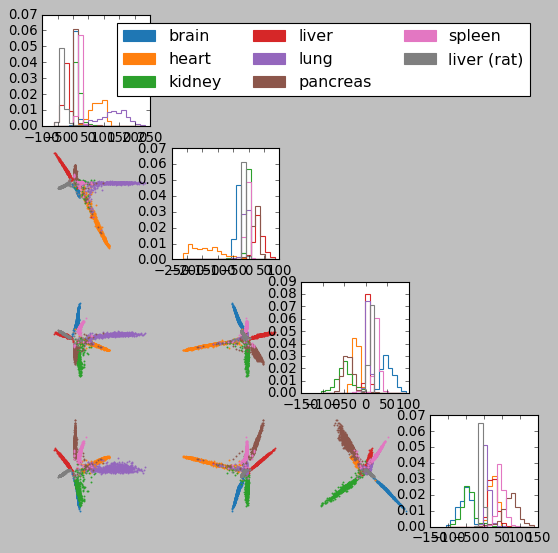

In [51]:
labelnames = {0:"brain", 1:"heart", 2:"kidney", 3:"liver", 4:"lung", 5:"pancreas", 6:"spleen", 7:"liver (rat)"}
plt.figure(figsize=(15,15))
make_corner(data_embeds,data_labels, labelnames)

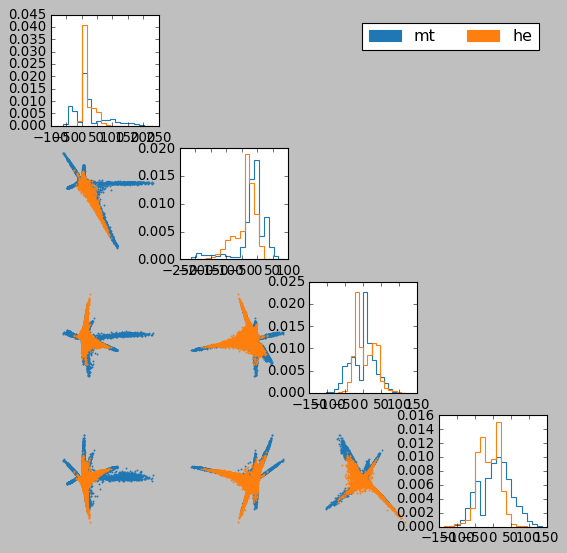

In [58]:
regular = data_embeds
shift = data_shift_embeds
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"mt",1:"he"})

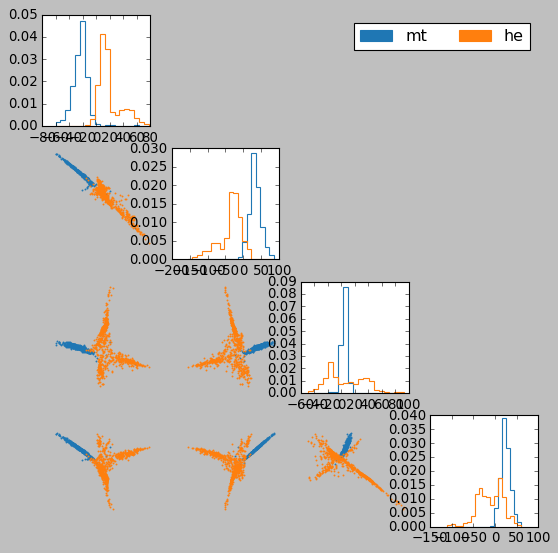

In [69]:
sel_label=3
regular = data_embeds[data_labels==sel_label]
shift = data_shift_embeds[data_labels==sel_label]
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"mt",1:"he"})

In [75]:
probs_data_shift = F.softmax(torch.tensor(data_shift_preds),dim=1).numpy()
probs_data = F.softmax(torch.tensor(data_preds),dim=1).numpy()

In [76]:
print("Embedding space classifier metrics for mt (default staining) test set")
auc = roc_auc_score(data_labels,probs_data,multi_class='ovr')
print("OVR auc = ",auc)
auc = roc_auc_score(data_labels,probs_data,multi_class='ovo')
print("OVO auc = ",auc)
for k in range(1,6):
    topk = top_k_accuracy_score(data_labels,probs_data,k=k)
    print(f"Top {k} acc = ",topk)

Embedding space classifier metrics for mt (default staining) test set


ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [79]:
data_embeds.shape

(5537, 4)

In [15]:
print("Embedding space classifier metrics for CIFAR5m tiny set")
auc = roc_auc_score(cifar5m_labels,probs_cifar5m,multi_class='ovr')
print("OVR auc = ",auc)
auc = roc_auc_score(cifar5m_labels,probs_cifar5m,multi_class='ovo')
print("OVO auc = ",auc)
for k in range(1,6):
    topk = top_k_accuracy_score(cifar5m_labels,probs_cifar5m,k=k)
    print(f"Top {k} acc = ",topk)

Embedding space classifier metrics for CIFAR5m tiny set
OVR auc =  0.9380215138499601
OVO auc =  0.9369496212175966
Top 1 acc =  0.6660657908818494
Top 2 acc =  0.8184128852739726
Top 3 acc =  0.8763678563784246
Top 4 acc =  0.9166410263270548
Top 5 acc =  0.944720542594178


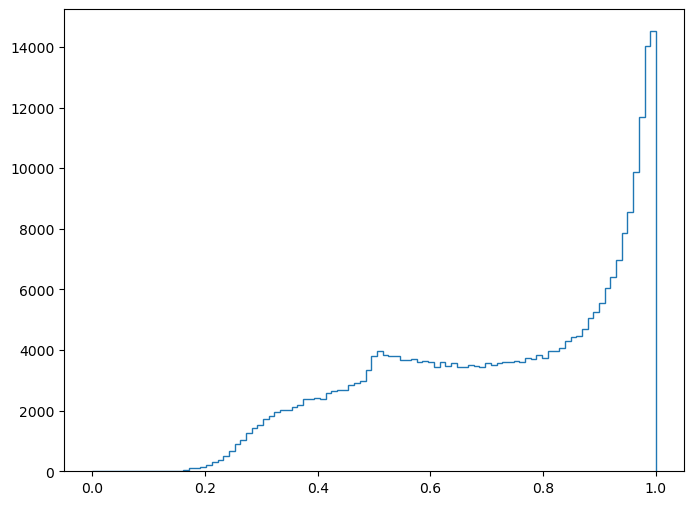

In [16]:
top_probs_cifar5m = np.max(probs_cifar5m,axis=1)
cifar5m_pred_classes = np.argmax(probs_cifar5m,axis=1)
plt.figure(figsize=(8,6))
h,bins,_ = plt.hist(top_probs_cifar5m,bins=np.linspace(0,1,100),histtype='step',density=False)

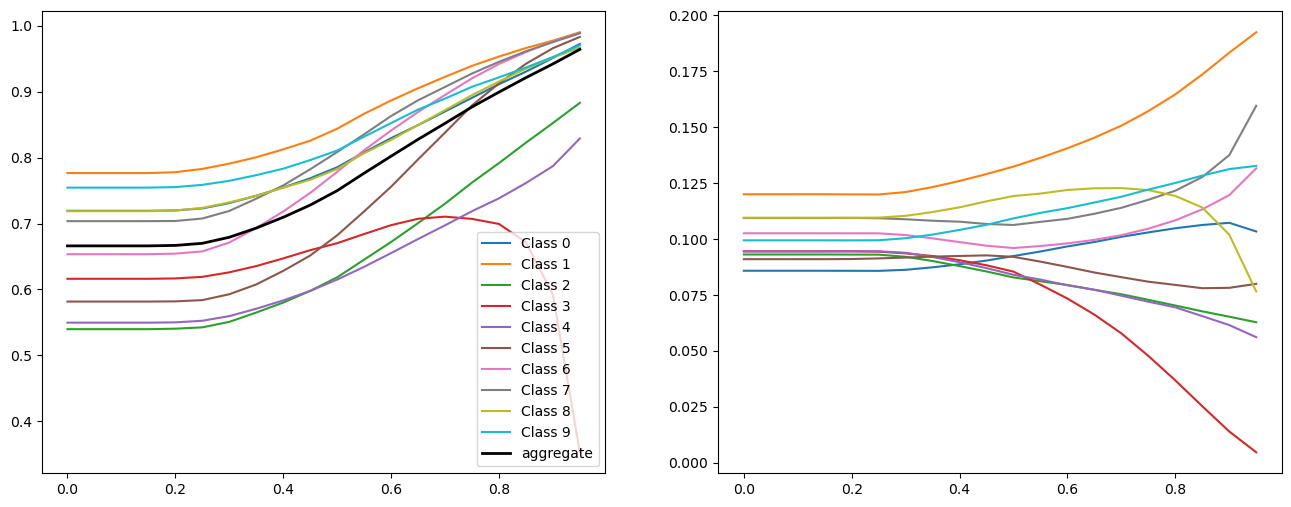

In [17]:
thresholds = np.arange(0,1,0.05)
fracs = {c:[] for c in range(10)}
breakdowns = {c:[] for c in range(10)}
totalFracs = []
for t in thresholds:
    cut = top_probs_cifar5m > t
    f_correct = np.count_nonzero(cifar5m_pred_classes[cut] == cifar5m_labels[cut]) / np.count_nonzero(cut)
    totalFracs.append(f_correct)
    for c in range(10):
        cut2 = cut & (cifar5m_labels == c)
        N = np.count_nonzero(cut2)
        fc = np.count_nonzero(cifar5m_pred_classes[cut2] == cifar5m_labels[cut2])/N
        fracs[c].append(fc)
        breakdowns[c].append(N/np.count_nonzero(cut))

        
fig,axes = plt.subplots(1,2,figsize=(16,6))
for c in range(10):
    plt.sca(axes[0])
    plt.plot(thresholds,fracs[c],label=f"Class {c}")
    plt.sca(axes[1])
    plt.plot(thresholds,breakdowns[c],label=f"Class {c}")
plt.sca(axes[0])
plt.plot(thresholds,totalFracs,lw=2,color='k',label="aggregate")
plt.legend()

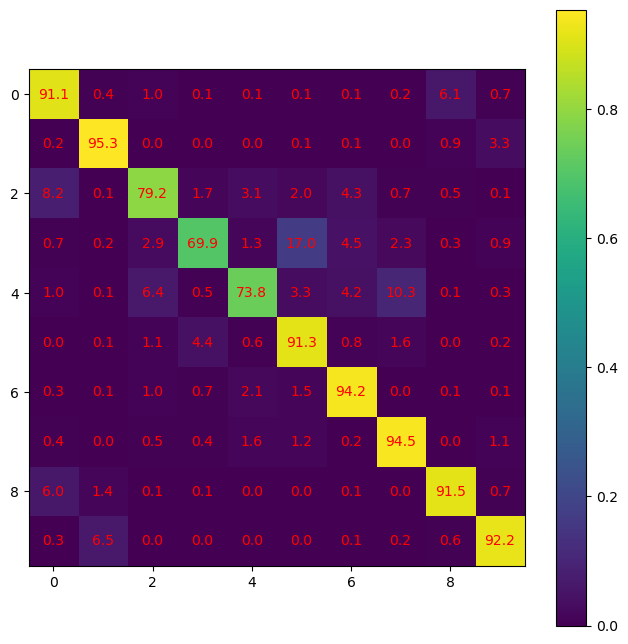

In [18]:
from sklearn.metrics import confusion_matrix
cut = top_probs_cifar5m > 0.8
mtx = confusion_matrix(cifar5m_labels[cut],cifar5m_pred_classes[cut],normalize='true')
plt.figure(figsize=(8,8))
plt.imshow(mtx)
plt.colorbar()
ax = plt.gca()
for i in range(mtx.shape[0]):
    for j in range(mtx.shape[1]):
        ax.text(j, i, f"{100*mtx[i, j]:.1f}",
                ha="center", va="center", color="red")

In [ ]:
cifar5m_finetune_dset = cifar5m_full.subselection(top_probs_cifar5m > 0.5)
cifar5m_finetune_train, cifar5m_finetune_test = cifar5m_finetune_dset.random_split(0.8)

In [ ]:
h=plt.hist(cifar5m_finetune_train.dataset[1],bins=np.arange(-0.5,10.5),histtype='step',density=True)
h=plt.hist(cifar5m_finetune_test.dataset[1],bins=np.arange(-0.5,10.5),histtype='step',density=True)

# fine tune v1: backbone only

In [14]:
from models.finetune import FineTuner
from models.revgrad import GradientReversal

#weights = torch.load(CHECKPOINT,
#                    map_location='cpu')
#sd = weights['state_dict']
#encoder_weights = {k.replace("encoder.",""):v for k,v in sd.items() if "encoder" in k}
#projector_weights = {k.replace("projector.",""):v for k,v in sd.items() if "projector" in k}
#classifier_weights = {k.replace("classifier.",""):v for k,v in sd.items() if "classifier" in k}

#encoder = CustomResNet("resnet50",[512,256,128],4)
#encoder.load_state_dict(encoder_weights)
#for param in encoder.parameters():
#    param.requires_grad = True

#projector = MLP(4,[4],4)
#projector.load_state_dict(projector_weights)

#corrector = MLP(4,[16,16],10,activation='relu')
#corrector.load_state_dict(classifier_weights)
#corrector = nn.Sequential(GradientReversal(alpha=1.0),corrector)
#corrector = None

domain_classifier = MLP(4,[8,8],1,activation='relu')
domain_classifier = nn.Sequential(GradientReversal(alpha=1.0),domain_classifier)
domain_classifier = domain_classifier.to(device)
tuner = SimCLRModel.load_from_checkpoint(CHECKPOINT)
#tuner = FineTuner(encoder,projector,corrector).to(device)

In [6]:
cifar = CIFAR10Dataset("resnet50",num_workers=2,batch_size=1024)
cifar_train_dataset = cifar.train_dataset
cifar_test_dataset = cifar.test_dataset

cifar5m_preds = np.load("cifar5m_classifierPreds_hueJitterNeg0p1_file0.npy")
hue_transform = v2.ColorJitter(hue=(-0.2,-0.2))
cifar5m_full = CIFAR5MDataset("resnet50",[0],[(None,None)],grayscale=False,custom_pre_transforms=[hue_transform])

In [7]:
nchunk = int(0.8 * len(cifar5m_preds))

cifar5m_finetune_train = cifar5m_full.subset(None,nchunk)
cifar5m_preds_train = cifar5m_preds[:nchunk]
cifar5m_probs_train = F.softmax(torch.tensor(cifar5m_preds_train),dim=1).numpy()

# limit to 10k test images for now
cifar5m_finetune_test = cifar5m_full.subset(nchunk,nchunk+10_000)
cifar5m_preds_test = cifar5m_preds[nchunk:nchunk+10_000]
cifar5m_probs_test = F.softmax(torch.tensor(cifar5m_preds_test),dim=1).numpy()

In [8]:
# select fine-tuning events based on threshold on top class probability
cut_threshold = 0.9 # threshold to cut on for training subsample; assigned class prob must be > threshold
cut_topProbs = np.max(cifar5m_probs_train,axis=1) > cut_threshold

cifar5m_finetune_train = cifar5m_finetune_train.subselection(cut_topProbs)
cifar5m_preds_train = cifar5m_preds_train[cut_topProbs]
cifar5m_probs_train = cifar5m_probs_train[cut_topProbs]

# choose a subsample of size Ntrain (50k for now so it's the same size as CIFAR10)
# balance the subsample to have equal label proportions
Ntrain = 50_0000
classes = sorted(list(set(cifar5m_finetune_train.labels)))
n_class = len(classes)
counts_per_class = [np.count_nonzero(cifar5m_finetune_train.labels == c) for c in classes]
nsel_per_class = min(Ntrain//n_class,np.min(counts_per_class))

all_indices = np.arange(len(cifar5m_finetune_train))
sel_indices = []
for c in classes:
    sel_indices.append(np.random.choice(all_indices[cifar5m_finetune_train.labels == c],
                                        size=nsel_per_class,
                                        replace=False))
sel_indices = np.concatenate(sel_indices)

cifar5m_finetune_train = cifar5m_finetune_train.subselection(sel_indices)
ifar5m_preds_train = cifar5m_preds_train[sel_indices]
cifar5m_probs_train = cifar5m_probs_train[sel_indices]

cifar5m_pred_classes_train = np.argmax(cifar5m_probs_train,axis=1)
cifar5m_classProbs_train = np.max(cifar5m_probs_train,axis=1)

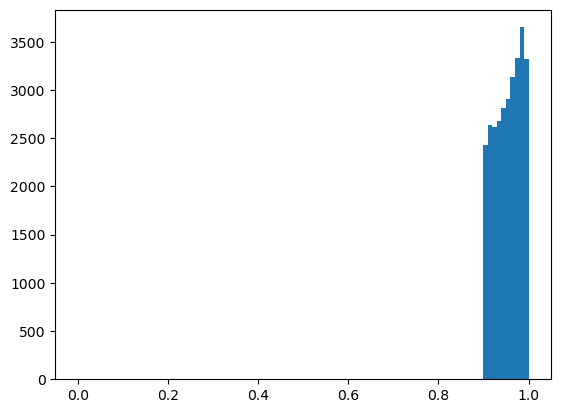

In [9]:
h = plt.hist(cifar5m_classProbs_train,bins=np.linspace(0,1,100))

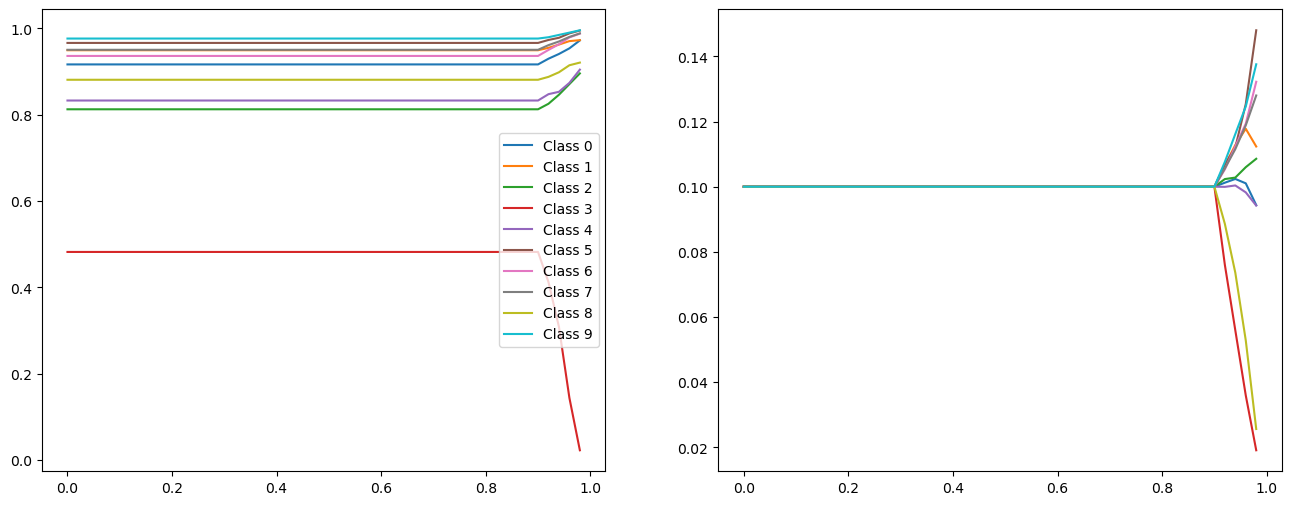

In [10]:
thresholds = np.arange(0,1,0.02)
fracs = {c:[] for c in range(10)}
breakdowns = {c:[] for c in range(10)}
totalFracs = []
for t in thresholds:
    cut = cifar5m_classProbs_train > t
    f_correct = np.count_nonzero(cifar5m_pred_classes_train[cut] == cifar5m_finetune_train.labels[cut]) / np.count_nonzero(cut)
    totalFracs.append(f_correct)
    for c in range(10):
        cut2 = cut & (cifar5m_finetune_train.labels == c)
        N = np.count_nonzero(cut2)
        fc = np.count_nonzero(cifar5m_pred_classes_train[cut2] == cifar5m_finetune_train.labels[cut2])/N
        fracs[c].append(fc)
        breakdowns[c].append(N/np.count_nonzero(cut))

        
fig,axes = plt.subplots(1,2,figsize=(16,6))
for c in range(10):
    plt.sca(axes[0])
    plt.plot(thresholds,fracs[c],label=f"Class {c}")
    plt.sca(axes[1])
    plt.plot(thresholds,breakdowns[c],label=f"Class {c}")
plt.sca(axes[0])
#plt.plot(thresholds,totalFracs,lw=2,color='k',label="aggregate")
plt.legend()

In [11]:
#### IMPORTANT #####
# change labels of domain-shifted data to be their predicted labels from the classifier trained on embeddings
cifar5m_finetune_train.labels = cifar5m_pred_classes_train

In [12]:
# create embeddings using initial model for later comparison

tuner = tuner.eval()

cifar_embeds_pretune = []
cifar_labels_pretune = []
for batch in tqdm(DataLoader(cifar_test_dataset,batch_size=1024,shuffle=True,num_workers=2)):
    x,labels = batch
    with torch.no_grad():
        cifar_embeds_pretune.append(tuner.encoder(x.to(device)).cpu().numpy())
        cifar_labels_pretune.append(labels.numpy())
cifar_embeds_pretune = np.concatenate(cifar_embeds_pretune)
cifar_labels_pretune = np.concatenate(cifar_labels_pretune)


cifar5m_test_embed_pretune = []
cifar5m_test_labels_pretune = []
for batch in tqdm(DataLoader(cifar5m_finetune_test,batch_size=1024,shuffle=True,num_workers=2)):
    x,labels = batch
    with torch.no_grad():
        cifar5m_test_embed_pretune.append(tuner.encoder(x.to(device)).cpu().numpy())
        cifar5m_test_labels_pretune.append(labels.numpy())
cifar5m_test_embed_pretune = np.concatenate(cifar5m_test_embed_pretune)
cifar5m_test_labels_pretune = np.concatenate(cifar5m_test_labels_pretune)

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


100%|██████████| 39/39 [00:23<00:00,  1.64it/s]


Epoch 1, Train: 6.30589, Val:7.24667, Val auc: 0.43620
	 Train (simclr): 5.17252, Val (simclr):5.52155
	 Train (class): 0.42232, Val (class):1.02100


100%|██████████| 39/39 [00:24<00:00,  1.58it/s]


Epoch 2, Train: 6.19315, Val:7.16896, Val auc: 0.46256
	 Train (simclr): 5.12603, Val (simclr):5.48997
	 Train (class): 0.37248, Val (class):0.97596


100%|██████████| 39/39 [00:26<00:00,  1.47it/s]


Epoch 3, Train: 6.09790, Val:7.13790, Val auc: 0.48266
	 Train (simclr): 5.08780, Val (simclr):5.49142
	 Train (class): 0.33795, Val (class):0.93907


100%|██████████| 39/39 [00:24<00:00,  1.58it/s]


Epoch 4, Train: 6.00735, Val:7.20169, Val auc: 0.48941
	 Train (simclr): 5.04682, Val (simclr):5.50099
	 Train (class): 0.30453, Val (class):0.97887


100%|██████████| 39/39 [00:25<00:00,  1.54it/s]

Epoch 5, Train: 5.92563, Val:7.22195, Val auc: 0.50524
	 Train (simclr): 5.00978, Val (simclr):5.49377
	 Train (class): 0.27224, Val (class):0.98127


Text(0.5, 1.0, 'Classifier Loss')

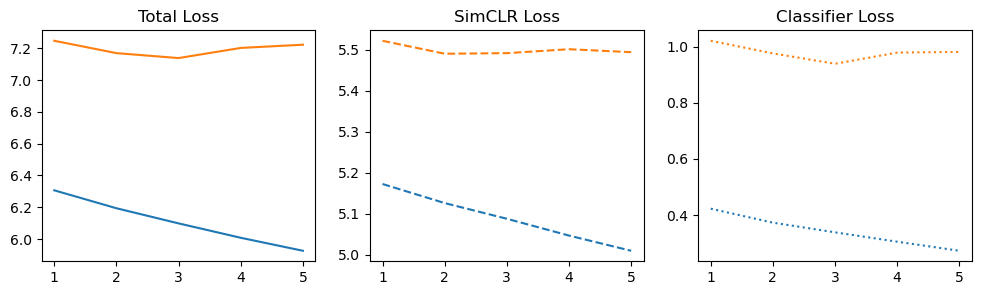

In [15]:
from models.losses import SupervisedSimCLRLoss

num_epoch = 5
patience_thresh = 5
criterion = SupervisedSimCLRLoss(temperature=0.5)
optimizer = torch.optim.AdamW(list(tuner.parameters())+list(domain_classifier.parameters()),lr=5e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epoch,eta_min=1e-5)

best_state = None
all_states = []
best_loss = 9999
patience = 0
train_losses = []
val_losses = []
train_simclr_losses = []
train_class_losses = []
val_simclr_losses = []
val_class_losses = []

train_loader = DataLoader(dutils.ConcatWithLabels([cifar_train_dataset,cifar5m_finetune_train],[0,1]),
                          batch_size=512,shuffle=True,num_workers=2,drop_last=True)
val_loader = DataLoader(dutils.ConcatWithLabels([cifar_test_dataset,cifar5m_finetune_test],[0,1]),
                        batch_size=512,shuffle=True,num_workers=2,drop_last=True)


tuner = tuner.train()
#pbar = tqdm(range(num_epoch),position=0,leave=True)
lambda_class = 1.0
lambda_domain = 1.0
for i in range(num_epoch):
    losses = []
    losses_simclr = []
    losses_class = []
    for batch in tqdm(train_loader):
        x,dset_label = batch
        x,labels = x
        h = tuner.encoder(x.to(device))
        preds = tuner.classifier(h)
        domain_preds = domain_classifier(h)
        domain_labels = (dset_label==1).float().to(device).unsqueeze(1)
        pos_mask = (labels.unsqueeze(1) == labels.unsqueeze(1).T).to(device) & (domain_labels == domain_labels.T)
        z = tuner.projector(h)
        z = F.normalize(z,dim=1).unsqueeze(1) # normalize the projection for simclr loss
        #loss_simclr = criterion(z, labels=labels)
        loss_simclr = criterion(z, mask=pos_mask)
        #loss_class = F.binary_cross_entropy_with_logits(preds,domain_labels)
        loss_class = F.cross_entropy(preds,labels.to(device))
        loss_domain = F.binary_cross_entropy_with_logits(domain_preds,domain_labels)
        loss = loss_simclr + lambda_class*loss_class + lambda_domain*loss_domain
        #loss = loss_simclr
        #loss = loss_class
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        losses_simclr.append(loss_simclr.item())
        losses_class.append(loss_class.item())
    train_losses.append(np.mean(losses))
    train_simclr_losses.append(np.mean(losses_simclr))
    train_class_losses.append(np.mean(losses_class))
    
    losses = []
    losses_simclr = []
    losses_class = []
    aucs = []
    for batch in tqdm(val_loader):
        x,dset_label = batch
        x,labels = x
        with torch.no_grad():
            h = tuner.encoder(x.to(device))
            preds = tuner.classifier(h)
            domain_preds = domain_classifier(h)
            domain_labels = (dset_label==1).float().to(device).unsqueeze(1)
            pos_mask = (labels.unsqueeze(1) == labels.unsqueeze(1).T).to(device) & (domain_labels == domain_labels.T)
            z = tuner.projector(h)
            z = F.normalize(z,dim=1).unsqueeze(1) # normalize the projection for simclr loss
            #loss_simclr = criterion(z, labels=labels)
            loss_simclr = criterion(z, mask=pos_mask)
            #loss_class = F.binary_cross_entropy_with_logits(preds,domain_labels)
            loss_class = F.cross_entropy(preds,labels.to(device))
            loss_domain = F.binary_cross_entropy_with_logits(domain_preds,domain_labels)
            loss = loss_simclr + lambda_class*loss_class + lambda_domain*loss_domain
            #loss = loss_simclr
            #loss = loss_class
            losses.append(loss.item())
            losses_simclr.append(loss_simclr.item())
            losses_class.append(loss_class.item())
            aucs.append(roc_auc_score(domain_labels.cpu().numpy()[:,0],torch.sigmoid(preds).cpu().numpy()[:,0]))
    losses = np.mean(losses)
    val_losses.append(losses)
    val_simclr_losses.append(np.mean(losses_simclr))
    val_class_losses.append(np.mean(losses_class))
    if losses < best_loss:
        best_loss = losses
        best_state = tuner.state_dict()
        patience = 0
    else:
        patience += 1
        if patience == patience_thresh:
            print(f"{patience_thresh} epochs of no improvement, stopping")
            break
    all_states.append(tuner.state_dict())
        
    #scheduler.step()
    
    #pbar.set_postfix_str(f"Train: {train_losses[-1]:.5f}, Val:{val_losses[-1]:.5f}")
    print(f"Epoch {i+1}, Train: {train_losses[-1]:.5f}, Val:{val_losses[-1]:.5f}, Val auc: {np.mean(aucs):.5f}")
    print(f"\t Train (simclr): {train_simclr_losses[-1]:.5f}, Val (simclr):{val_simclr_losses[-1]:.5f}")
    print(f"\t Train (class): {train_class_losses[-1]:.5f}, Val (class):{val_class_losses[-1]:.5f}")
    
tuner.load_state_dict(best_state)

fig,axes = plt.subplots(1,3,figsize=(12,3))
x = np.arange(1,len(train_losses)+1)

plt.sca(axes[0])
plt.plot(x,train_losses,label='train',color="C0")
plt.plot(x,val_losses,label='val',color="C1")
plt.title("Total Loss")

plt.sca(axes[1])
plt.plot(x,train_simclr_losses,label='train (simclr)',color="C0",linestyle='--')
plt.plot(x,val_simclr_losses,label='val (simclr)',color="C1",linestyle='--')
plt.title("SimCLR Loss")

plt.sca(axes[2])
plt.plot(x,train_class_losses,label='train (class)',color="C0",linestyle=':')
plt.plot(x,val_class_losses,label='val (class)',color="C1",linestyle=':')
plt.title("Classifier Loss")

In [16]:
tuner.load_state_dict(best_state)
tuner = tuner.eval()

cifar_embeds_tune = []
cifar_labels_tune = []
cifar_domainProbs_tune = []
cifar_preds_tune = []
for batch in tqdm(DataLoader(cifar_test_dataset,batch_size=1024,shuffle=True,num_workers=2)):
    x,labels = batch
    with torch.no_grad():
        cifar_embeds_tune.append(tuner.encoder(x.to(device)).cpu().numpy())
        cifar_labels_tune.append(labels.numpy())
        cifar_domainProbs_tune.append(torch.sigmoid(tuner.classifier(torch.tensor(cifar_embeds_tune[-1]).to(device))).cpu().numpy())
        cifar_preds_tune.append(tuner.classifier(torch.tensor(cifar_embeds_tune[-1]).to(device)).cpu().numpy())
cifar_embeds_tune = np.concatenate(cifar_embeds_tune)
cifar_labels_tune = np.concatenate(cifar_labels_tune)
cifar_domainProbs_tune = np.concatenate(cifar_domainProbs_tune)
cifar_preds_tune = np.concatenate(cifar_preds_tune)


cifar5m_test_embed_tune = []
cifar5m_test_labels_tune = []
cifar5m_test_domainProbs_tune = []
cifar5m_test_preds_tune = []
for batch in tqdm(DataLoader(cifar5m_finetune_test,batch_size=1024,shuffle=True,num_workers=2)):
    x,labels = batch
    with torch.no_grad():
        cifar5m_test_embed_tune.append(tuner.encoder(x.to(device)).cpu().numpy())
        cifar5m_test_labels_tune.append(labels.numpy())
        cifar5m_test_domainProbs_tune.append(torch.sigmoid(tuner.classifier(torch.tensor(cifar5m_test_embed_tune[-1]).to(device))).cpu().numpy())
        cifar5m_test_preds_tune.append(tuner.classifier(torch.tensor(cifar5m_test_embed_tune[-1]).to(device)).cpu().numpy())
cifar5m_test_embed_tune = np.concatenate(cifar5m_test_embed_tune)
cifar5m_test_labels_tune = np.concatenate(cifar5m_test_labels_tune)
cifar5m_test_domainProbs_tune = np.concatenate(cifar5m_test_domainProbs_tune)
cifar5m_test_preds_tune = np.concatenate(cifar5m_test_preds_tune)

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


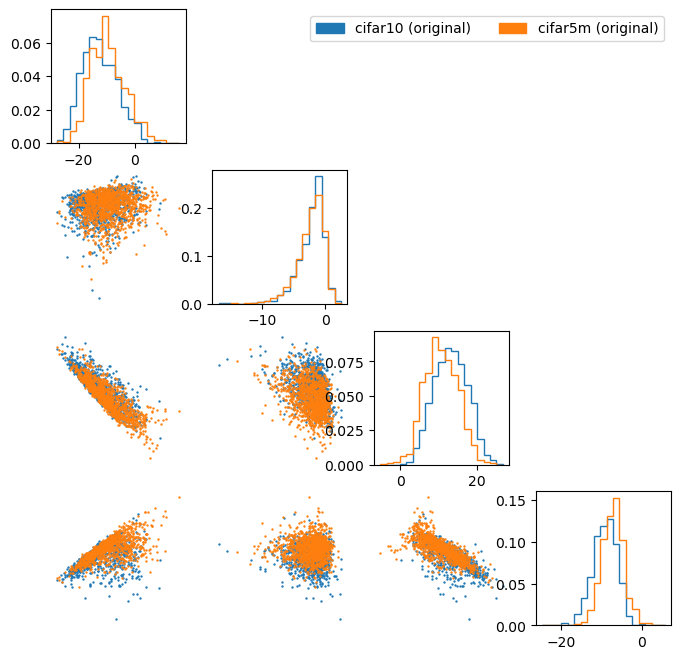

In [17]:
# pre-tune

from utils.plotting import make_corner
sel_label=1
regular = cifar_embeds_pretune[cifar_labels_pretune==sel_label]
shift = cifar5m_test_embed_pretune[cifar5m_test_labels_pretune==sel_label]
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"cifar10 (original)",1:"cifar5m (original)"})

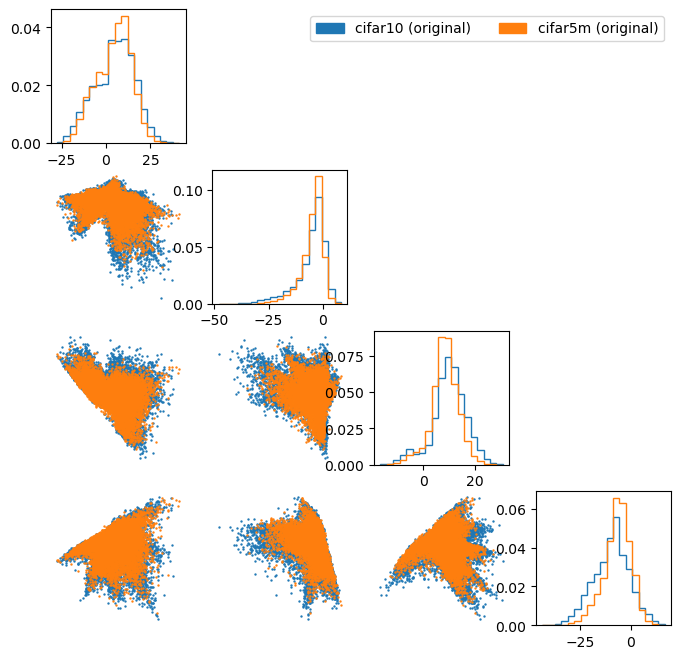

In [18]:
# full space pre-tune

from utils.plotting import make_corner
regular = cifar_embeds_pretune
shift = cifar5m_test_embed_pretune
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"cifar10 (original)",1:"cifar5m (original)"})

Text(0.5, 1.0, 'CIFAR label 6')

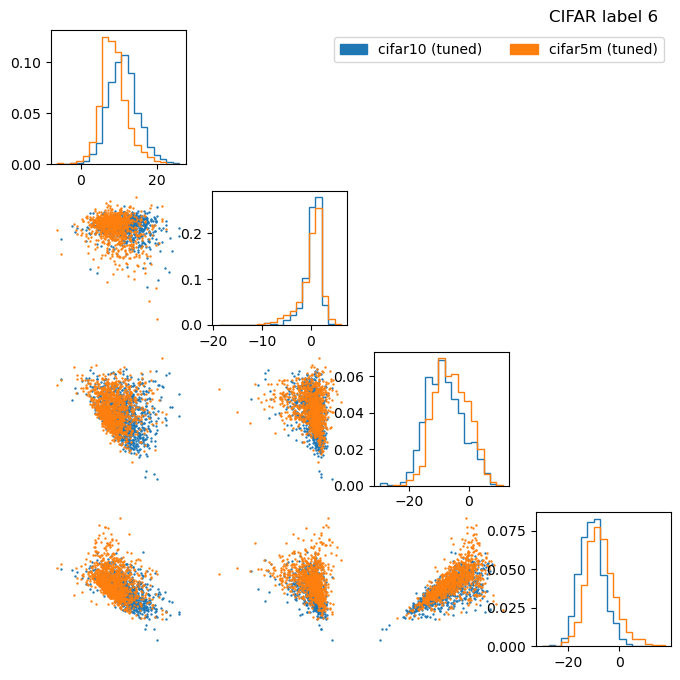

In [19]:
# post-tune

from utils.plotting import make_corner
sel_label=6
regular = cifar_embeds_tune[cifar_labels_tune==sel_label]
shift = cifar5m_test_embed_tune[cifar5m_test_labels_tune==sel_label]
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"cifar10 (tuned)",1:"cifar5m (tuned)"})
plt.title(f"CIFAR label {sel_label}")

Text(0.5, 1.0, 'CIFAR label 6')

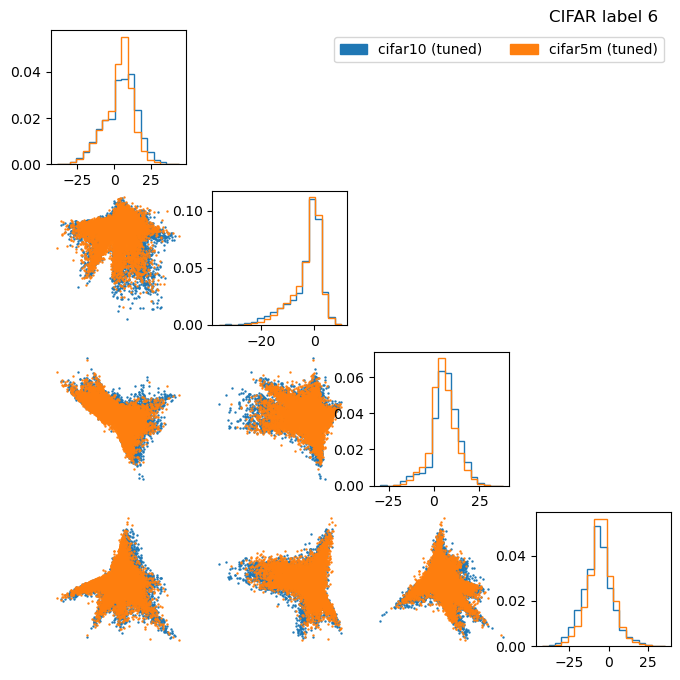

In [20]:
# compare full space
from utils.plotting import make_corner
regular = cifar_embeds_tune
shift = cifar5m_test_embed_tune
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"cifar10 (tuned)",1:"cifar5m (tuned)"})
plt.title(f"CIFAR label {sel_label}")

In [21]:
print("Embedding space classifier metrics for CIFAR10 test set")
probs_cifar_tune = F.softmax(torch.tensor(cifar_preds_tune),dim=1).numpy()
auc = roc_auc_score(cifar_labels_tune,probs_cifar_tune,multi_class='ovr')
print("OVR auc = ",auc)
auc = roc_auc_score(cifar_labels_tune,probs_cifar_tune,multi_class='ovo')
print("OVO auc = ",auc)
for k in range(1,6):
    topk = top_k_accuracy_score(cifar_labels_tune,probs_cifar_tune,k=k)
    print(f"Top {k} acc = ",topk)

Embedding space classifier metrics for CIFAR10 test set
OVR auc =  0.9729708888888888
OVO auc =  0.9729708888888889
Top 1 acc =  0.7879
Top 2 acc =  0.898
Top 3 acc =  0.9347
Top 4 acc =  0.9574
Top 5 acc =  0.9733


In [22]:
print("Embedding space classifier metrics for CIFAR5m tiny set")
probs_cifar5m_test_tune = F.softmax(torch.tensor(cifar5m_test_preds_tune),dim=1).numpy()
auc = roc_auc_score(cifar5m_test_labels_tune,probs_cifar5m_test_tune,multi_class='ovr')
print("OVR auc = ",auc)
auc = roc_auc_score(cifar5m_test_labels_tune,probs_cifar5m_test_tune,multi_class='ovo')
print("OVO auc = ",auc)
for k in range(1,6):
    topk = top_k_accuracy_score(cifar5m_test_labels_tune,probs_cifar5m_test_tune,k=k)
    print(f"Top {k} acc = ",topk)

Embedding space classifier metrics for CIFAR5m tiny set
OVR auc =  0.929573322358235
OVO auc =  0.9283832177713195
Top 1 acc =  0.6434
Top 2 acc =  0.8026
Top 3 acc =  0.8661
Top 4 acc =  0.9099
Top 5 acc =  0.9384


In [68]:
torch.save(tuner.state_dict(),"tuner_cifar10tocifar5m.pt")